In [1]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 420 kB/s 
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=371efff4f8d6fc5a0d1193bcf310bda3cc013e08fbf8e82a804753190c96a8ba
  Stored in directory: /root/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile


In [2]:
!pip install wwo-hist 

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/solar-power-electricity-production/ikitelli-gune-enerjisi-santrali-elektrik-uretim-miktarlar (1).xlsx
/kaggle/input/no-data-sources/empty.csv


In [4]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from wwo_hist import retrieve_hist_data
import plotly.express as px
import plotly.graph_objects as go
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
import shap
from sklearn.model_selection import train_test_split,TimeSeriesSplit
import lightgbm
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from termcolor import colored

# Metadata

Data : https://data.ibb.gov.tr/dataset/ikitelli-gunes-enerjisi-santrali-elektrik-uretim-miktarlari

In [5]:
path="/kaggle/input/solar-power-electricity-production/ikitelli-gune-enerjisi-santrali-elektrik-uretim-miktarlar (1).xlsx"
metadata=pd.read_excel(path,sheet_name="Metadata_EN")
metadata

,Name,Electricity Generation Quantities of from the İkitelli Solar Power Plant
0,Explanation,It includes 15-minute data per day from the 12...
1,Category,"Energy, Environment"
2,Keywords,"Energy, production, Ges, electricity, power pl..."
3,Publisher,İstanbul Energy Inc.
4,Data Date Range,"May 2018, May 2019"
5,Creator,İstanbul Energy Inc.
6,Created date,2020-01-01 00:00:00
7,Geographic Data Included?,No
8,Data Update Frequency,Monthly
9,type,Real data


# Creating Data

In [6]:
february_data=pd.read_excel(path,sheet_name="Şubat-2019")
march_data=pd.read_excel(path,sheet_name="Mart-2019")
april_data=pd.read_excel(path,sheet_name="Nisan-2019")
full_df=pd.concat([february_data,march_data])
full_df=pd.concat([full_df,april_data]).rename({"Tarih":"date_time","Üretim (kWh)":"production"},axis=1)
df=full_df.copy()
df.head()

,date_time,production
0,2019-02-01 06:00:00,0
1,2019-02-01 06:15:00,0
2,2019-02-01 06:30:00,0
3,2019-02-01 06:45:00,0
4,2019-02-01 07:00:00,0


In [7]:
df.dtypes.to_frame().T

,date_time,production
0,datetime64[ns],int64


In [8]:
df.date_time.min(),df.date_time.max()

(Timestamp('2019-02-01 06:00:00'), Timestamp('2019-04-30 22:45:00'))

In [9]:
fig = px.line(df, x='date_time', y='production', title='İkitelli Solar Power Electricity Production - Period:15 Minutes')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

# Getting Weather Data with WorldWeatherOnline API and Adding Features

https://www.worldweatheronline.com/developer/

In [10]:
def extract_from_date(data):
    data["month"]=data.date_time.dt.month
    data["week"]=data.date_time.dt.week
    data["hour"]=data.date_time.dt.hour
    data["time"]=data.date_time.dt.time
    data['dayofweek'] = data.date_time.dt.dayofweek
    data["dayofmonth"]=data.date_time.dt.day
    data["day_name"]=data.date_time.dt.day_name()
    data['is_weekend'] = np.where(data['day_name'].isin(['Sunday', 'Saturday']), 1,0)
    return data

In [11]:
df=extract_from_date(df)
df.head()

,date_time,production,month,week,hour,time,dayofweek,dayofmonth,day_name,is_weekend
0,2019-02-01 06:00:00,0,2,5,6,06:00:00,4,1,Friday,0
1,2019-02-01 06:15:00,0,2,5,6,06:15:00,4,1,Friday,0
2,2019-02-01 06:30:00,0,2,5,6,06:30:00,4,1,Friday,0
3,2019-02-01 06:45:00,0,2,5,6,06:45:00,4,1,Friday,0
4,2019-02-01 07:00:00,0,2,5,7,07:00:00,4,1,Friday,0


In [12]:
api_key="ce5f333abfd24db6950113925211702"
location_list=["Istanbul"]
frequency="1"
start_date="1-FEBRUARY-2019"
end_date="30-APRIL-2019"

hist_weather_data=retrieve_hist_data(api_key=api_key,
                                    location_list=location_list,
                                    start_date=start_date,
                                    frequency=frequency,
                                    end_date=end_date,
                                    location_label=False,
                                    export_csv=True,
                                    store_df=True)



Retrieving weather data for Istanbul


Currently retrieving data for Istanbul: from 2019-02-01 to 2019-02-28
Time elapsed (hh:mm:ss.ms) 0:00:04.195699
Currently retrieving data for Istanbul: from 2019-03-01 to 2019-03-31
Time elapsed (hh:mm:ss.ms) 0:00:10.999046
Currently retrieving data for Istanbul: from 2019-04-01 to 2019-04-30
Time elapsed (hh:mm:ss.ms) 0:00:15.521804


export Istanbul completed!




In [13]:
weather_data=pd.read_csv("Istanbul.csv")
weather_data.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2019-02-01 00:00:00,12,10,0.0,8.3,3,8,05:44 AM,03:23 PM,08:15 AM,06:20 PM,6,8,11,8,57,67,68,0.1,1007,11,10,223,40,Istanbul
1,2019-02-01 01:00:00,12,10,0.0,8.3,3,8,05:44 AM,03:23 PM,08:15 AM,06:20 PM,6,8,11,8,58,77,69,0.1,1008,11,10,228,40,Istanbul
2,2019-02-01 02:00:00,12,10,0.0,8.3,3,8,05:44 AM,03:23 PM,08:15 AM,06:20 PM,6,7,11,7,58,88,70,0.2,1008,11,10,233,40,Istanbul
3,2019-02-01 03:00:00,12,10,0.0,8.3,3,8,05:44 AM,03:23 PM,08:15 AM,06:20 PM,6,7,11,7,58,98,71,0.2,1009,11,10,238,41,Istanbul
4,2019-02-01 04:00:00,12,10,0.0,8.3,3,8,05:44 AM,03:23 PM,08:15 AM,06:20 PM,6,7,10,7,54,99,73,0.1,1010,10,10,245,38,Istanbul


In [14]:
weather_data.dtypes.to_frame().T

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,object,int64,int64,float64,float64,int64,int64,object,object,object,object,int64,int64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,object


In [15]:
weather_data.date_time=pd.to_datetime(weather_data.date_time)
weather_data.date_time.dtypes

dtype('<M8[ns]')

In [16]:
weather_data=extract_from_date(weather_data)
weather_data.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location,month,week,hour,time,dayofweek,dayofmonth,day_name,is_weekend
0,2019-02-01 00:00:00,12,10,0.0,8.3,3,8,05:44 AM,03:23 PM,08:15 AM,06:20 PM,6,8,11,8,57,67,68,0.1,1007,11,10,223,40,Istanbul,2,5,0,00:00:00,4,1,Friday,0
1,2019-02-01 01:00:00,12,10,0.0,8.3,3,8,05:44 AM,03:23 PM,08:15 AM,06:20 PM,6,8,11,8,58,77,69,0.1,1008,11,10,228,40,Istanbul,2,5,1,01:00:00,4,1,Friday,0
2,2019-02-01 02:00:00,12,10,0.0,8.3,3,8,05:44 AM,03:23 PM,08:15 AM,06:20 PM,6,7,11,7,58,88,70,0.2,1008,11,10,233,40,Istanbul,2,5,2,02:00:00,4,1,Friday,0
3,2019-02-01 03:00:00,12,10,0.0,8.3,3,8,05:44 AM,03:23 PM,08:15 AM,06:20 PM,6,7,11,7,58,98,71,0.2,1009,11,10,238,41,Istanbul,2,5,3,03:00:00,4,1,Friday,0
4,2019-02-01 04:00:00,12,10,0.0,8.3,3,8,05:44 AM,03:23 PM,08:15 AM,06:20 PM,6,7,10,7,54,99,73,0.1,1010,10,10,245,38,Istanbul,2,5,4,04:00:00,4,1,Friday,0


In [17]:
weather_data.date_time = pd.to_datetime(weather_data.date_time)
feats=['date_time','maxtempC','mintempC','sunHour','uvIndex','cloudcover','tempC','FeelsLikeC',
                           'humidity','HeatIndexC','precipMM','WindChillC','winddirDegree','windspeedKmph',"dayofmonth","hour","month"]

weather_new=weather_data[feats]
weather_new.head()

,date_time,maxtempC,mintempC,sunHour,uvIndex,cloudcover,tempC,FeelsLikeC,humidity,HeatIndexC,precipMM,WindChillC,winddirDegree,windspeedKmph,dayofmonth,hour,month
0,2019-02-01 00:00:00,12,10,8.3,3,67,11,8,68,11,0.1,8,223,40,1,0,2
1,2019-02-01 01:00:00,12,10,8.3,3,77,11,8,69,11,0.1,8,228,40,1,1,2
2,2019-02-01 02:00:00,12,10,8.3,3,88,11,7,70,11,0.2,7,233,40,1,2,2
3,2019-02-01 03:00:00,12,10,8.3,3,98,11,7,71,11,0.2,7,238,41,1,3,2
4,2019-02-01 04:00:00,12,10,8.3,3,99,10,7,73,10,0.1,7,245,38,1,4,2


In [18]:
full_data=pd.merge(df,weather_new,
                   on=['dayofmonth','hour',"month"],
                   how='left').rename({"date_time_x":"date_time"},axis=1).drop("date_time_y",axis=1)
full_data.head()

,date_time,production,month,week,hour,time,dayofweek,dayofmonth,day_name,is_weekend,maxtempC,mintempC,sunHour,uvIndex,cloudcover,tempC,FeelsLikeC,humidity,HeatIndexC,precipMM,WindChillC,winddirDegree,windspeedKmph
0,2019-02-01 06:00:00,0,2,5,6,06:00:00,4,1,Friday,0,12,10,8.3,3,100,10,6,77,10,0.5,6,259,32
1,2019-02-01 06:15:00,0,2,5,6,06:15:00,4,1,Friday,0,12,10,8.3,3,100,10,6,77,10,0.5,6,259,32
2,2019-02-01 06:30:00,0,2,5,6,06:30:00,4,1,Friday,0,12,10,8.3,3,100,10,6,77,10,0.5,6,259,32
3,2019-02-01 06:45:00,0,2,5,6,06:45:00,4,1,Friday,0,12,10,8.3,3,100,10,6,77,10,0.5,6,259,32
4,2019-02-01 07:00:00,0,2,5,7,07:00:00,4,1,Friday,0,12,10,8.3,3,98,10,6,75,10,0.2,6,260,30


In [19]:
day_mean_prod=full_data.groupby(["dayofmonth","month"])["production"].mean()
full_data=pd.merge(full_data,day_mean_prod,on=["dayofmonth","month"]).rename({"production_x":"production","production_y":"day_mean_prod"},axis=1)
full_data.head()

,date_time,production,month,week,hour,time,dayofweek,dayofmonth,day_name,is_weekend,maxtempC,mintempC,sunHour,uvIndex,cloudcover,tempC,FeelsLikeC,humidity,HeatIndexC,precipMM,WindChillC,winddirDegree,windspeedKmph,day_mean_prod
0,2019-02-01 06:00:00,0,2,5,6,06:00:00,4,1,Friday,0,12,10,8.3,3,100,10,6,77,10,0.5,6,259,32,38.926471
1,2019-02-01 06:15:00,0,2,5,6,06:15:00,4,1,Friday,0,12,10,8.3,3,100,10,6,77,10,0.5,6,259,32,38.926471
2,2019-02-01 06:30:00,0,2,5,6,06:30:00,4,1,Friday,0,12,10,8.3,3,100,10,6,77,10,0.5,6,259,32,38.926471
3,2019-02-01 06:45:00,0,2,5,6,06:45:00,4,1,Friday,0,12,10,8.3,3,100,10,6,77,10,0.5,6,259,32,38.926471
4,2019-02-01 07:00:00,0,2,5,7,07:00:00,4,1,Friday,0,12,10,8.3,3,98,10,6,75,10,0.2,6,260,30,38.926471


In [20]:
full_data["prod(t-1)"]=full_data.production.shift(1)
full_data["prod(t-2)"]=full_data.production.shift(2)
full_data["prod(t-3)"]=full_data.production.shift(3)
full_data["prod(t-4)"]=full_data.production.shift(4)
full_data["prod(t-5)"]=full_data.production.shift(5)
full_data["prod(t-6)"]=full_data.production.shift(6)
full_data["prod(t-12)"]=full_data.production.shift(12)
full_data["prod(t-24)"]=full_data.production.shift(24)
full_data["prod(t-48)"]=full_data.production.shift(48)

In [21]:
full_data.head(3)

,date_time,production,month,week,hour,time,dayofweek,dayofmonth,day_name,is_weekend,maxtempC,mintempC,sunHour,uvIndex,cloudcover,tempC,FeelsLikeC,humidity,HeatIndexC,precipMM,WindChillC,winddirDegree,windspeedKmph,day_mean_prod,prod(t-1),prod(t-2),prod(t-3),prod(t-4),prod(t-5),prod(t-6),prod(t-12),prod(t-24),prod(t-48)
0,2019-02-01 06:00:00,0,2,5,6,06:00:00,4,1,Friday,0,12,10,8.3,3,100,10,6,77,10,0.5,6,259,32,38.926471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-02-01 06:15:00,0,2,5,6,06:15:00,4,1,Friday,0,12,10,8.3,3,100,10,6,77,10,0.5,6,259,32,38.926471,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-02-01 06:30:00,0,2,5,6,06:30:00,4,1,Friday,0,12,10,8.3,3,100,10,6,77,10,0.5,6,259,32,38.926471,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
full_data["prod(t-1)"].fillna(method ='bfill',inplace=True)
full_data["prod(t-2)"].fillna(method="bfill",inplace=True)
full_data["prod(t-3)"].fillna(method="bfill",inplace=True)
full_data["prod(t-4)"].fillna(method="bfill",inplace=True)
full_data["prod(t-5)"].fillna(method="bfill",inplace=True)
full_data["prod(t-6)"].fillna(method="bfill",inplace=True)
full_data["prod(t-12)"].fillna(method="bfill",inplace=True)
full_data["prod(t-24)"].fillna(method="bfill",inplace=True)
full_data["prod(t-48)"].fillna(method="bfill",inplace=True)

In [23]:
full_data.head(3)

,date_time,production,month,week,hour,time,dayofweek,dayofmonth,day_name,is_weekend,maxtempC,mintempC,sunHour,uvIndex,cloudcover,tempC,FeelsLikeC,humidity,HeatIndexC,precipMM,WindChillC,winddirDegree,windspeedKmph,day_mean_prod,prod(t-1),prod(t-2),prod(t-3),prod(t-4),prod(t-5),prod(t-6),prod(t-12),prod(t-24),prod(t-48)
0,2019-02-01 06:00:00,0,2,5,6,06:00:00,4,1,Friday,0,12,10,8.3,3,100,10,6,77,10,0.5,6,259,32,38.926471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-02-01 06:15:00,0,2,5,6,06:15:00,4,1,Friday,0,12,10,8.3,3,100,10,6,77,10,0.5,6,259,32,38.926471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-02-01 06:30:00,0,2,5,6,06:30:00,4,1,Friday,0,12,10,8.3,3,100,10,6,77,10,0.5,6,259,32,38.926471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
X=full_data.drop("production",axis=1)
y=full_data["production"]
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False,test_size=24*4*4)
train=pd.concat([X_train,y_train],axis=1)
test=pd.concat([X_test,y_test],axis=1)
train.set_index("date_time",inplace=True)
test.set_index("date_time",inplace=True)
train.shape,test.shape

((5637, 32), (384, 32))

In [25]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
month,5637.0,2.957956,0.791527,2.000000,2.000000,3.000000,4.000000,4.000000
week,5637.0,11.032109,3.461468,5.000000,8.000000,11.000000,14.000000,17.000000
hour,5637.0,13.972858,4.903809,6.000000,10.000000,14.000000,18.000000,22.000000
dayofweek,5637.0,3.000887,2.009161,0.000000,1.000000,3.000000,5.000000,6.000000
dayofmonth,5637.0,14.523683,8.243156,1.000000,7.000000,14.000000,21.000000,31.000000
is_weekend,5637.0,0.288629,0.453165,0.000000,0.000000,0.000000,1.000000,1.000000
maxtempC,5637.0,12.969842,3.663277,4.000000,10.000000,13.000000,16.000000,22.000000
mintempC,5637.0,8.859500,2.496439,3.000000,7.000000,9.000000,11.000000,15.000000
sunHour,5637.0,9.648856,2.117769,5.100000,8.400000,10.300000,11.600000,11.600000
uvIndex,5637.0,3.416356,0.973733,1.000000,3.000000,4.000000,4.000000,5.000000


# Visualizations

month,2,3,4
production,31.947062,66.447042,74.162833


day_name,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
production,60.931677,71.644526,49.785714,67.474847,46.185714,62.065594,41.414005


dayofweek,0,1,2,3,4,5,6
production,71.644526,62.065594,41.414005,46.185714,60.931677,49.785714,67.474847


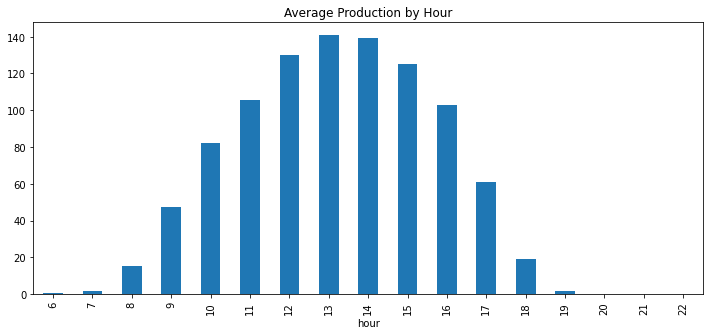

In [26]:
display(train.groupby("month")["production"].mean().to_frame().T)
display(train.groupby("day_name")["production"].mean().to_frame().T)
display(train.groupby("dayofweek")["production"].mean().to_frame().T)
train.groupby("hour")["production"].mean().plot.bar(figsize=(12,5),title="Average Production by Hour");

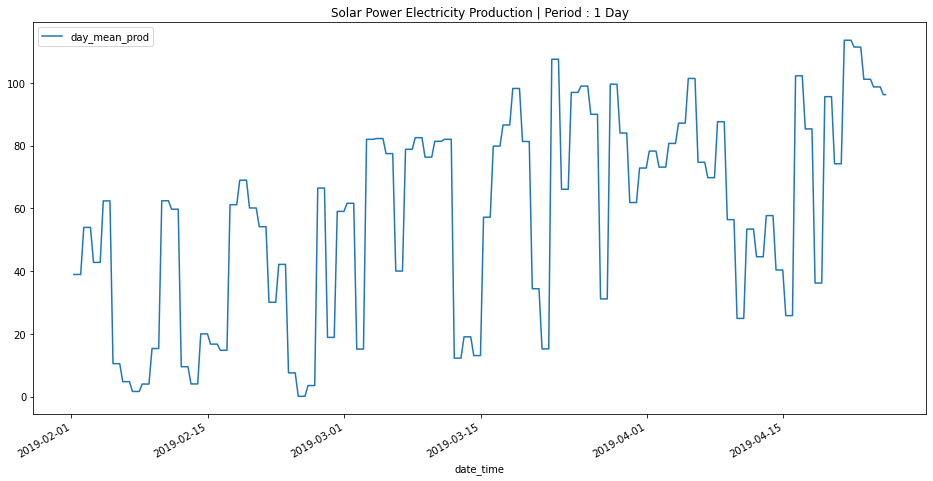

In [27]:
train.plot.line(y='day_mean_prod',figsize=(16,8),
                    title="Solar Power Electricity Production | Period : 1 Day");

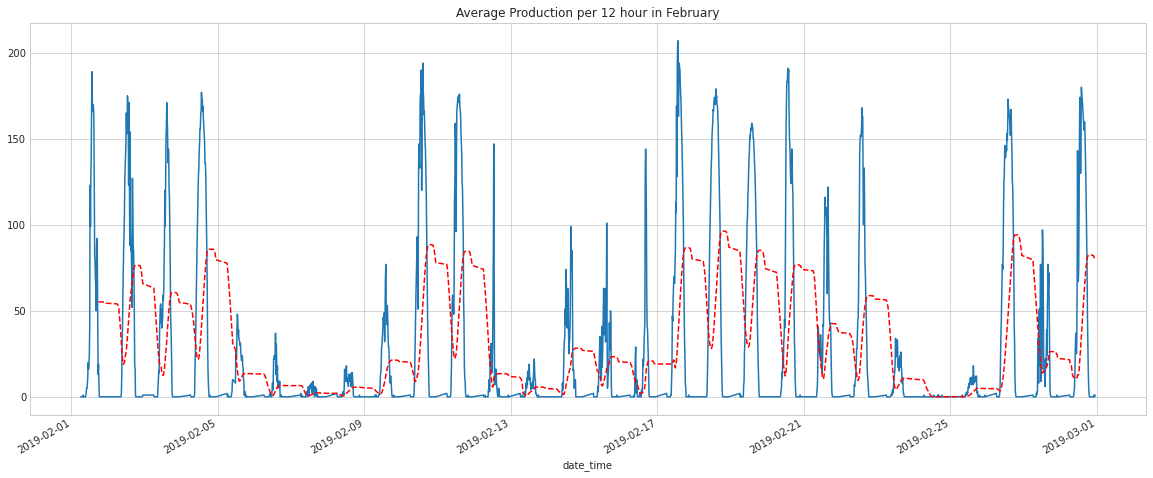

In [28]:
with plt.style.context('seaborn-whitegrid'):
    train.loc[train.month==2].production.plot(figsize=(20,8));
    train.loc[train.month==2].rolling(window=48).mean()["production"].plot(figsize=(20,8),ls="--",c="red");
    plt.title("Average Production per 12 hour in February");

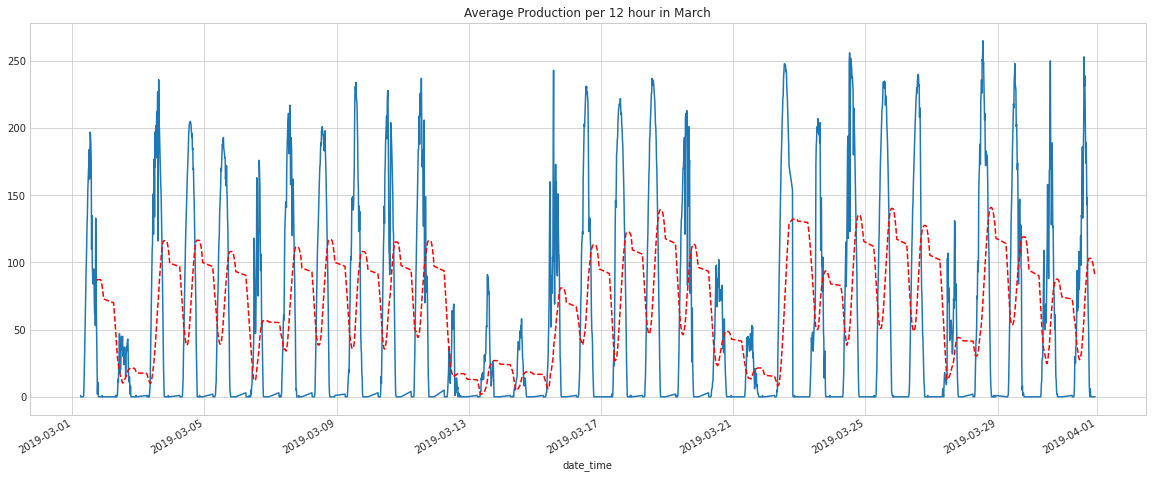

In [29]:
with plt.style.context('seaborn-whitegrid'):
    train.loc[train.month==3].production.plot(figsize=(20,8));
    train.loc[train.month==3].rolling(window=48).mean()["production"].plot(figsize=(20,8),ls="--",c="red");
    plt.title("Average Production per 12 hour in March");

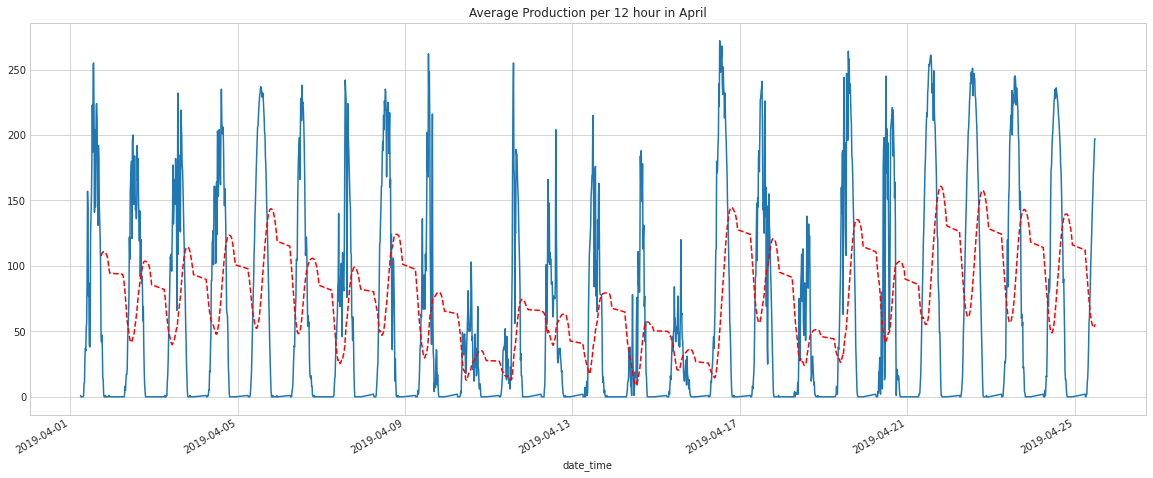

In [30]:
with plt.style.context('seaborn-whitegrid'):
    train.loc[train.month==4].production.plot(figsize=(20,8));
    train.loc[train.month==4].rolling(window=48).mean()["production"].plot(figsize=(20,8),ls="--",c="red");
    plt.title("Average Production per 12 hour in April");

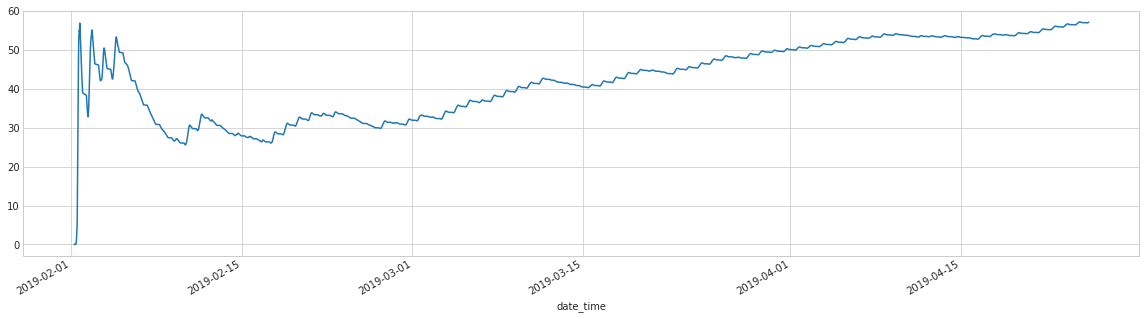

In [31]:
with plt.style.context('seaborn-whitegrid'):
    train.production.expanding().mean().plot(figsize=(20,5)); #average of all prior rows

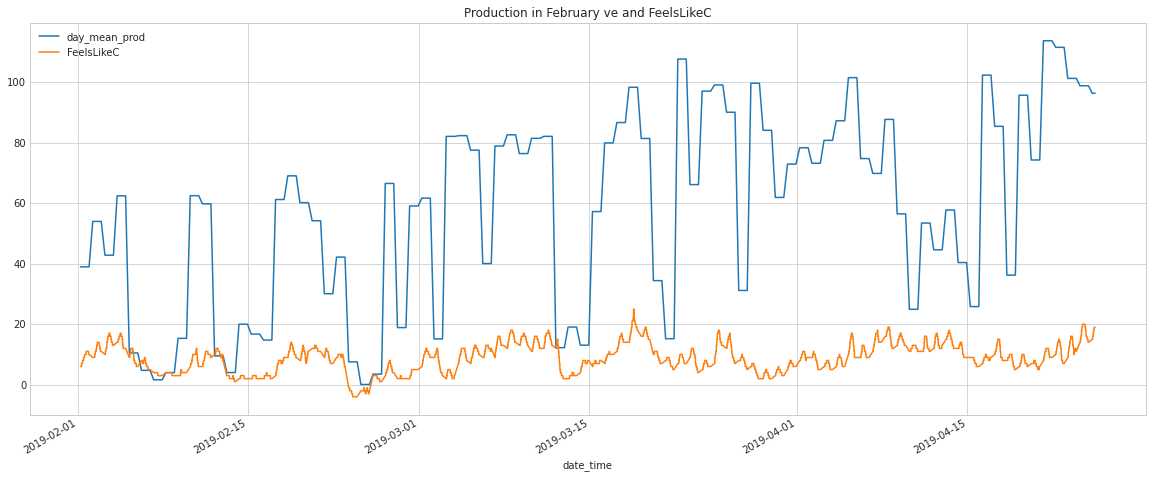

In [32]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(20,8))

    ax.set_title('Production in February ve and FeelsLikeC')
    ax = train.plot.line(y=['day_mean_prod',"FeelsLikeC"],ax=ax)

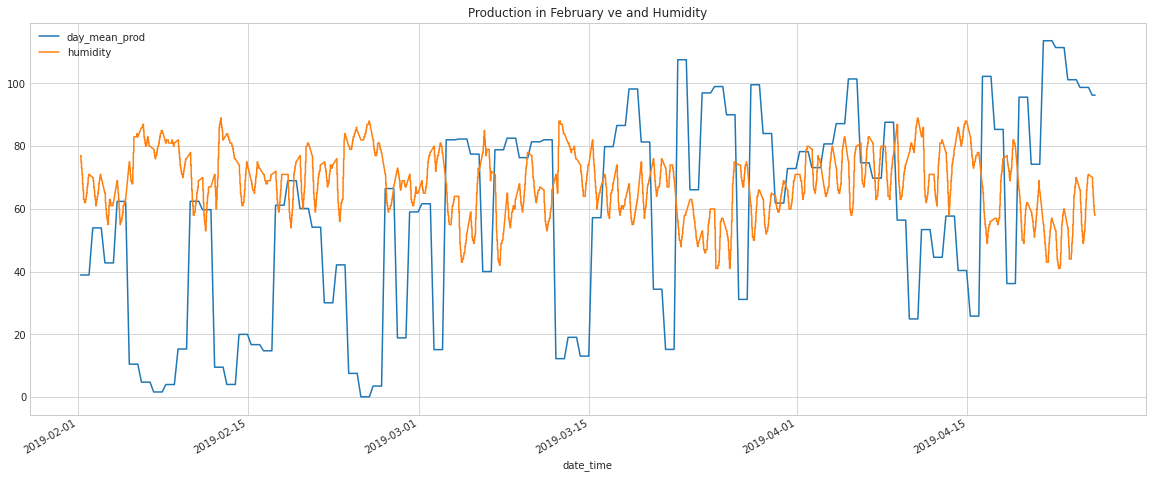

In [33]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(20,8))

    ax.set_title('Production in February ve and Humidity')
    ax = train.plot.line(y=['day_mean_prod',"humidity"],ax=ax)

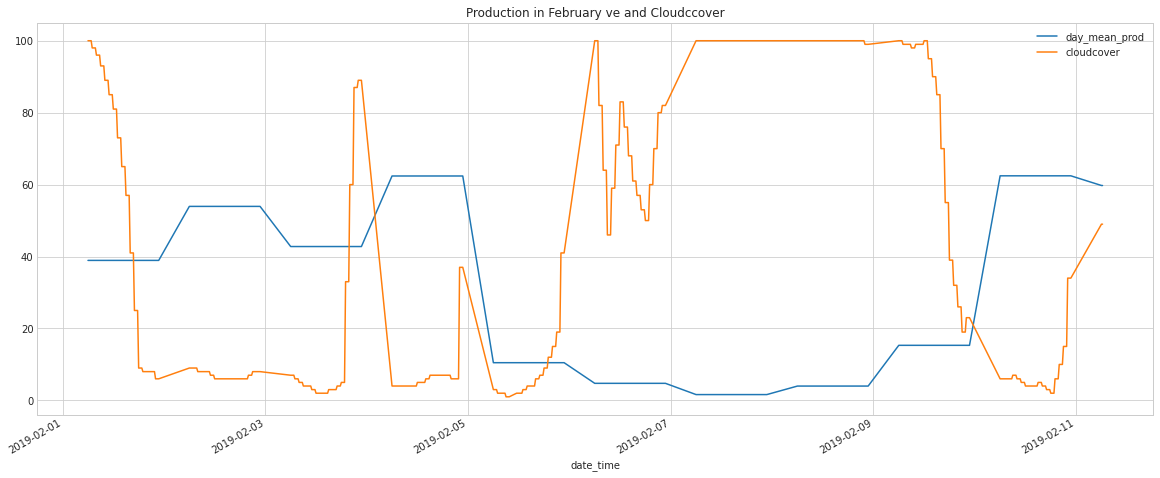

In [34]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(20,8))

    ax.set_title('Production in February ve and Cloudccover')
    ax = train.head(4*168).plot.line(y=['day_mean_prod',"cloudcover"],ax=ax)

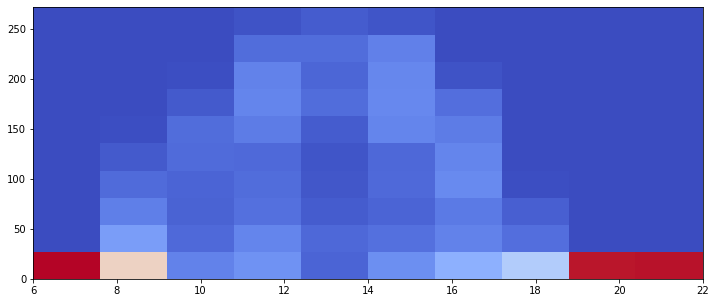

In [35]:
plt.figure(figsize=(12,5));
plt.hist2d(x=train.hour,y=train.production,cmap="coolwarm");

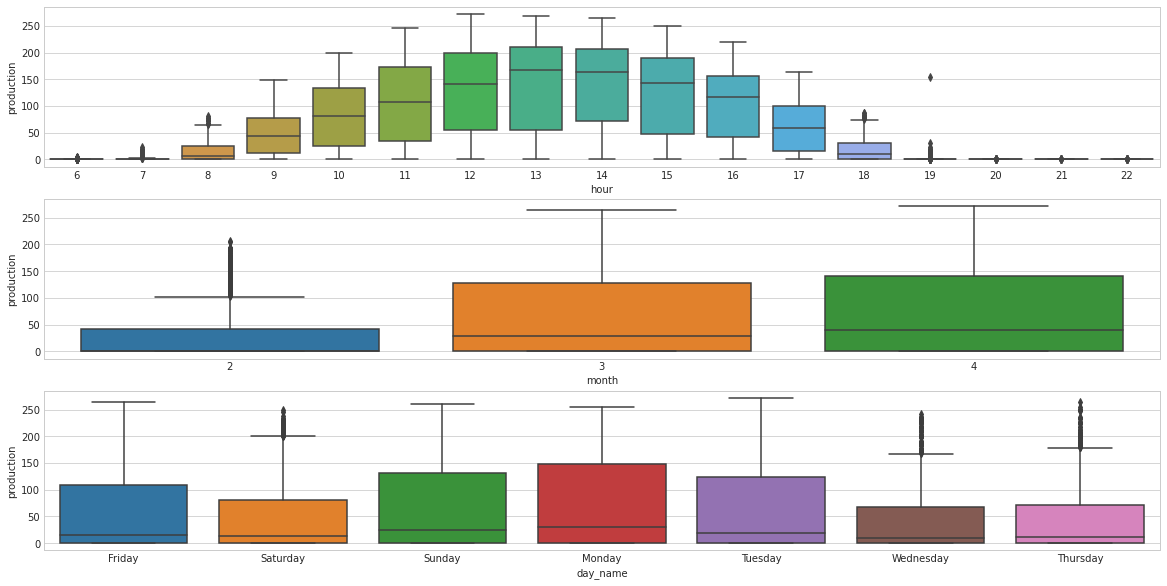

In [36]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(20,10));
    plt.subplot(311)
    sns.boxplot(x="hour",y="production",data=train);
    plt.subplot(312)
    sns.boxplot(x="month",y="production",data=train);
    plt.subplot(313)
    sns.boxplot(x="day_name",y="production",data=train);

In [37]:
train.corr()["production"].nlargest(10).to_frame()

,production
production,1.000000
prod(t-1),0.970579
prod(t-2),0.940175
prod(t-3),0.909357
prod(t-4),0.874770
prod(t-5),0.838876
prod(t-6),0.794112
prod(t-12),0.451818
HeatIndexC,0.449371
tempC,0.448703


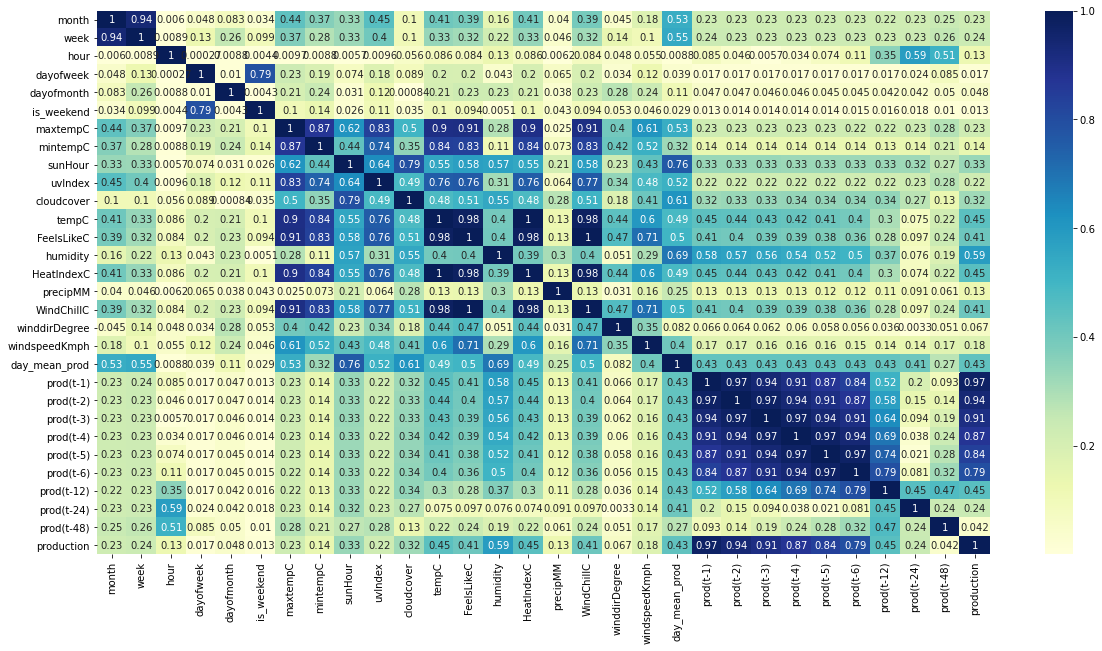

In [38]:
plt.figure(figsize=(20,10));
sns.heatmap(train.corr().abs(),annot=True,cmap="YlGnBu");

# TimeSeriesSplit CV

In [39]:
params = {
    'max_depth':3,
    'objective': 'regression',
    'metric': ['mape','rmse'],
    'num_leaves': 4,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
tscv=TimeSeriesSplit(n_splits=5)
full_df=full_data.drop(["date_time","time","day_name"],axis=1)
X=full_df.drop(["production"],axis=1)
y=full_df["production"]
scores=[]
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    model=LGBMRegressor(random_state=0,max_depth=3,metric=['mape','rmse']) 
    train = lightgbm.Dataset(X_train,y_train)
    val = lightgbm.Dataset(X_test,y_test,reference=train)
    print('Train and Validate')
    model = lightgbm.train(params=params,train_set=train,valid_sets=val,
                           num_boost_round=10000,verbose_eval=10,early_stopping_rounds=50)
    score=model.best_score.items()
    scores.append(score)
print("Best Scores: ",scores)

TRAIN: [   0    1    2 ... 1003 1004 1005] TEST: [1006 1007 1008 ... 2006 2007 2008]
Train and Validate
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 50 rounds
[10]	valid_0's mape: 8.71112	valid_0's rmse: 37.2278
[20]	valid_0's mape: 5.59725	valid_0's rmse: 25.0632
[30]	valid_0's mape: 3.76323	valid_0's rmse: 18.5043
[40]	valid_0's mape: 2.50718	valid_0's rmse: 14.8979
[50]	valid_0's mape: 1.84952	valid_0's rmse: 13.0927
[60]	valid_0's mape: 1.37087	valid_0's rmse: 12.2189
[70]	valid_0's mape: 1.07111	valid_0's rmse: 11.769
[80]	valid_0's mape: 0.868224	valid_0's rmse: 11.4472
[90]	valid_0's mape: 0.700705	valid_0's rmse: 11.2394
[100]	valid_0's mape: 0.629461	valid_0's rmse: 11.2107
[110]	valid_0's mape: 0.594107	valid_0's rmse: 11.2111
[120]	valid_0's ma

In [40]:
X=full_data.drop("production",axis=1)
y=full_data["production"]
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False,test_size=24*4*4)
train=pd.concat([X_train,y_train],axis=1)
test=pd.concat([X_test,y_test],axis=1)
train.set_index("date_time",inplace=True)
test.set_index("date_time",inplace=True)

columns=train.columns.difference(["time","day_name","month","mintempC","maxtempC","is_weekend",
                                  "tempC","uvIndex","week","WindChillC","HeatIndexC"])
train=train[columns]
test=test[columns]
X_train=train.drop(["production"],axis=1)
X_test=test.drop(["production"],axis=1)
y_train=train["production"]
y_test=test["production"]

# LGBM Model

In [41]:
model=LGBMRegressor(random_state=0,reg_lambda=0.5,reg_alpha=0.8)
#model=LGBMRegressor(max_depth=3,learning_rate=0.05,num_leaves=4,metric=['mape','rmse'],objective='regression')
model.fit(X_train,y_train)
pred=model.predict(X_test)
result=pd.DataFrame({"test":y_test,"pred":pred})

In [42]:
result.loc[result.pred<0,"pred"]=0 
# There are some negative values and I'm turning them into zero. If you have any advice about it, please comment.Thanks in advance.

In [43]:
result.head(16)

,test,pred
date_time,,
2019-04-25 12:00:00,205,208.555161
2019-04-25 12:15:00,212,216.535264
2019-04-25 12:30:00,217,218.422247
2019-04-25 12:45:00,225,224.013666
2019-04-25 13:00:00,223,229.836387
2019-04-25 13:15:00,226,236.081359
2019-04-25 13:30:00,232,232.357472
2019-04-25 13:45:00,224,236.583657
2019-04-25 14:00:00,171,228.383950


In [44]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=result.test,
                    mode='lines',
                    name='test'))
fig.add_trace(go.Scatter(y=result.pred,
                    mode='lines',
                    name='pred'))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Solar Power Electricity Production Prediction Result',
                   xaxis_title='Date',
                   yaxis_title='Production')
fig.show()

In [45]:
def error_table(y_pred,y_test):
    mse=mean_squared_error(y_test,y_pred)
    rmse=np.sqrt(mse)
    mae=mean_absolute_error(y_test,y_pred)

    r2=r2_score(y_test,y_pred)
    table_error=pd.DataFrame({"MSE":mse,"RMSE":rmse,"MAE":mae,"R2":r2},index=[0])
    return table_error

In [46]:
model.score(X_train,y_train)

0.9853614951074035

In [47]:
error_table(pred,y_test)

,MSE,RMSE,MAE,R2
0,142.208739,11.925131,6.934868,0.981096


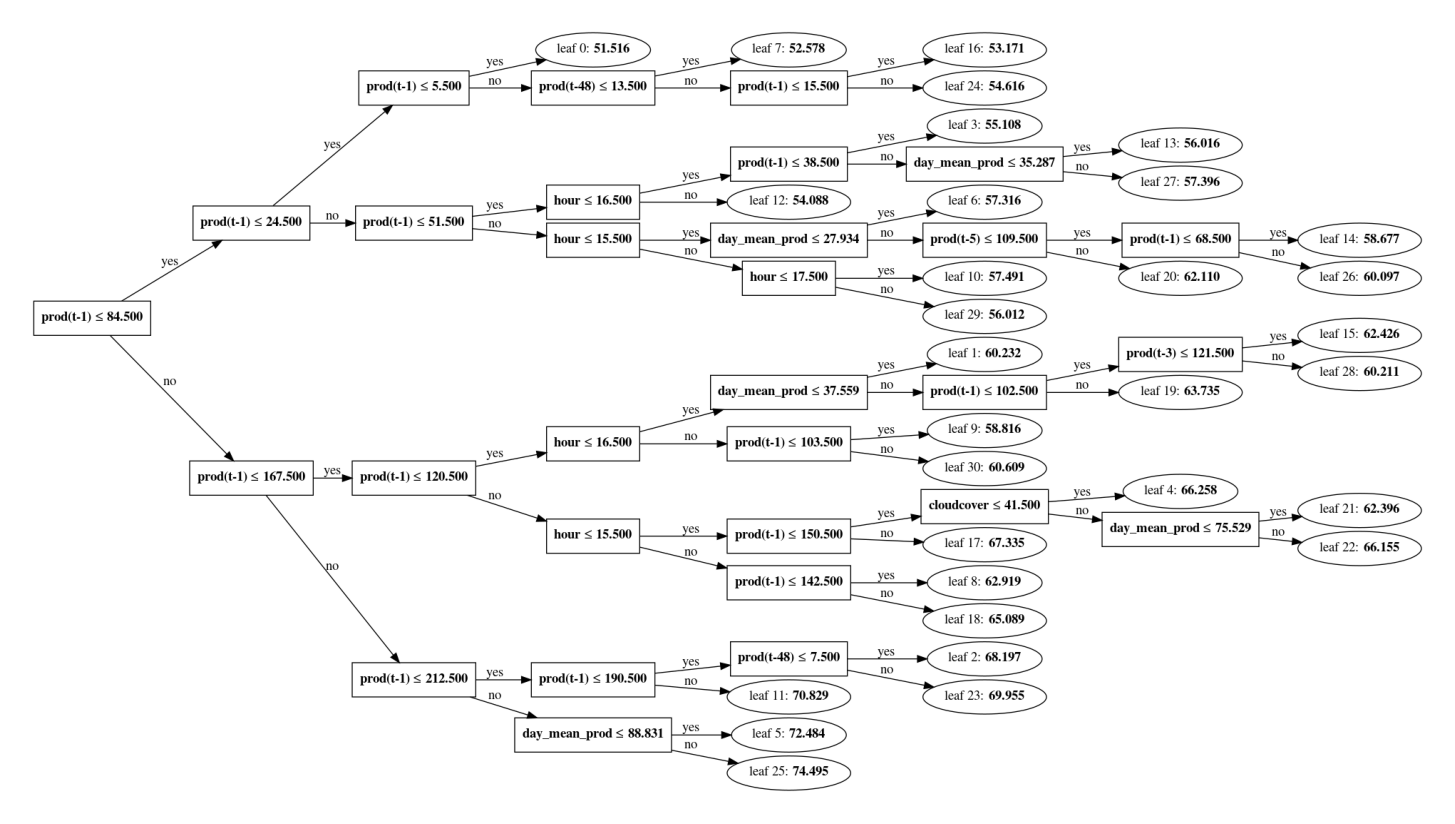

In [48]:
lightgbm.plot_tree(model,dpi=300);

# Feature Importance

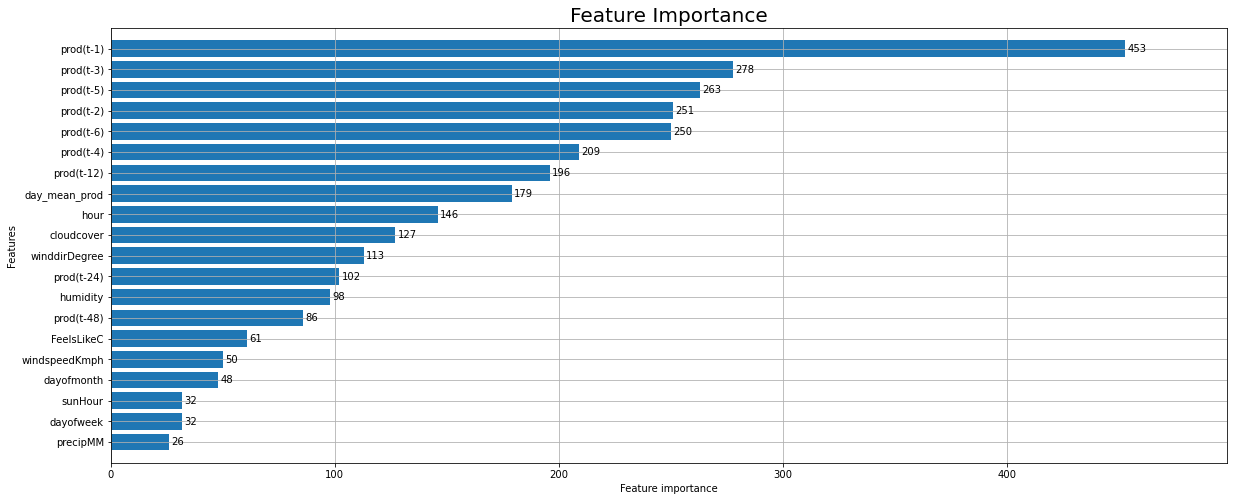

In [49]:
fig, ax = plt.subplots(figsize=(20,8));
lightgbm.plot_importance(model,ax=ax,importance_type='split',height=0.8);
plt.title("Feature Importance",fontsize=20);

# Permutation Importance

In [50]:
perm = PermutationImportance(model, random_state=0).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(),top=50)

Weight,Feature
1.4771 ± 0.1091,prod(t-1)
0.0164 ± 0.0029,prod(t-5)
0.0160 ± 0.0007,hour
0.0145 ± 0.0040,prod(t-3)
0.0054 ± 0.0021,prod(t-2)
0.0023 ± 0.0009,prod(t-4)
0.0012 ± 0.0009,prod(t-24)
0.0011 ± 0.0009,prod(t-6)
0.0007 ± 0.0008,prod(t-48)
0.0006 ± 0.0007,humidity


# Partial Dependence Plots

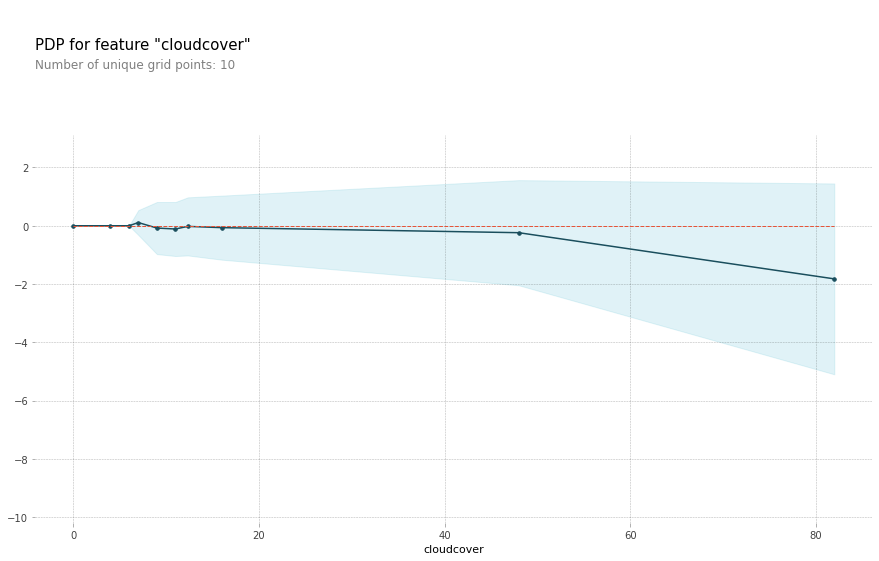

In [51]:
pdp_prod= pdp.pdp_isolate(model=model, dataset=X_test, model_features=X_test.columns, feature='cloudcover')
pdp.pdp_plot(pdp_prod, 'cloudcover')
plt.show()

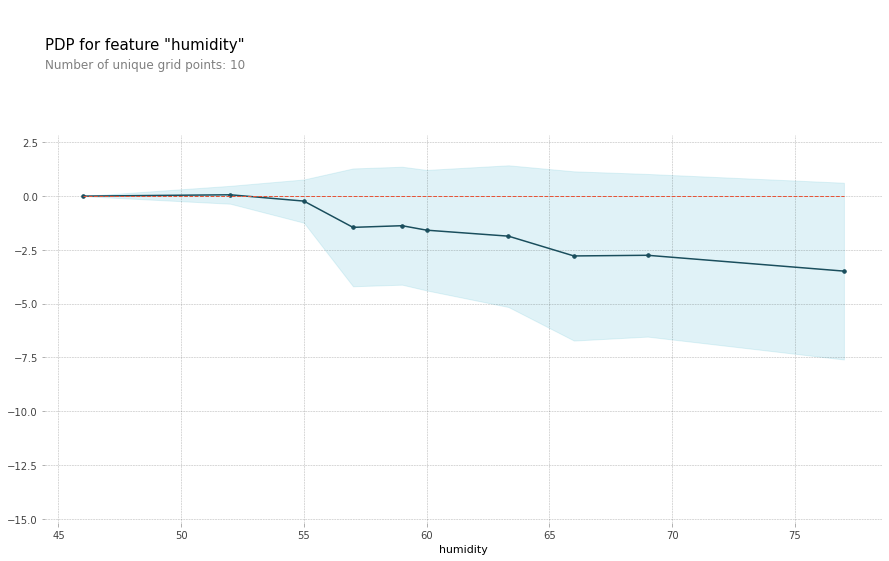

In [52]:
pdp_prod= pdp.pdp_isolate(model=model, dataset=X_test, model_features=X_test.columns, feature='humidity')
pdp.pdp_plot(pdp_prod, 'humidity')
plt.show()

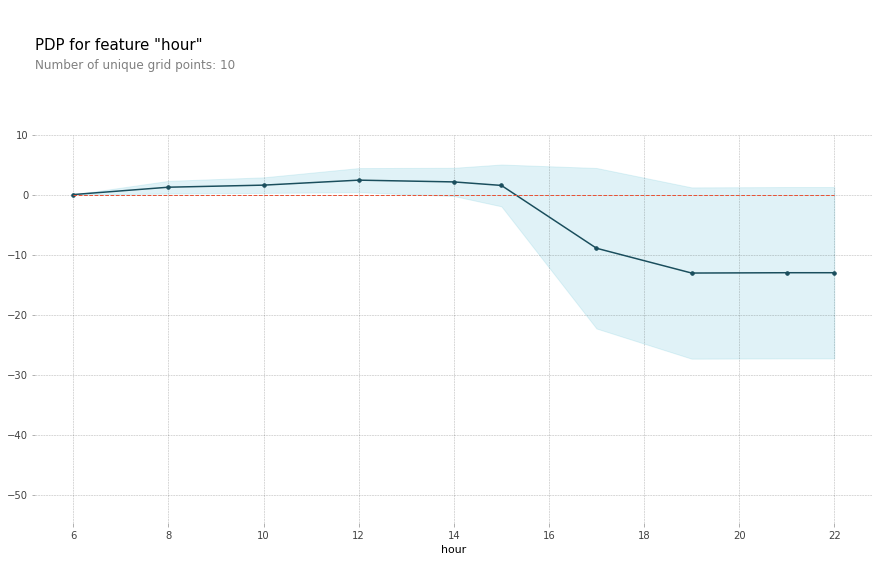

In [53]:
pdp_prod= pdp.pdp_isolate(model=model, dataset=X_test, model_features=X_test.columns, feature='hour')
pdp.pdp_plot(pdp_prod, 'hour')
plt.show()

# SHAP Values

In [54]:
shap.initjs()

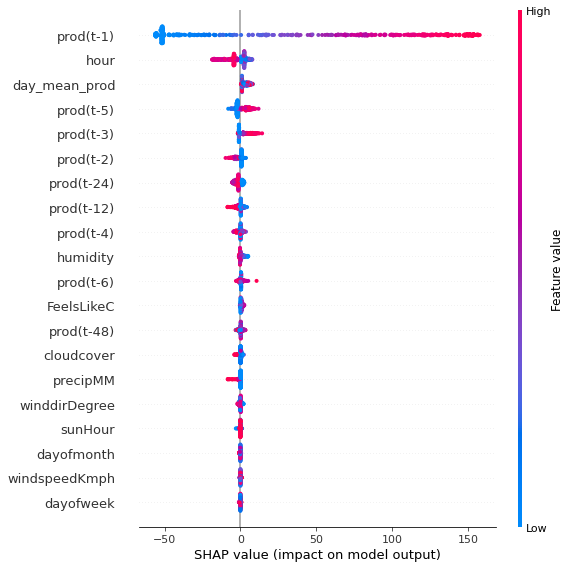

In [55]:

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

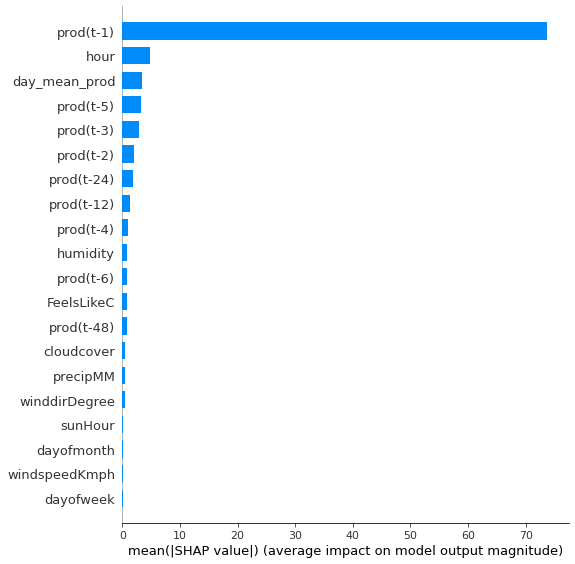

In [56]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [57]:
shap.force_plot(explainer.expected_value, shap_values, X_test)

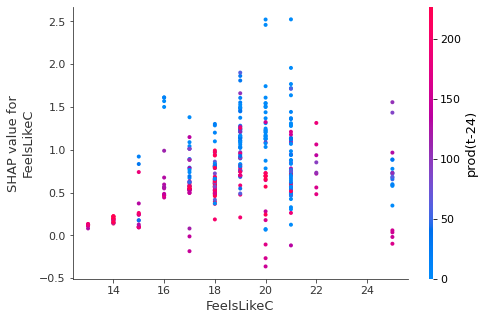

In [58]:
shap.dependence_plot("FeelsLikeC", shap_values, X_test)